In [2]:
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import numpy as np
import random

overlay = Overlay('./ls_ip.bit')

In [ ]:
# overlay?

In [3]:
dma = overlay.axi_dma_0
leastsq = overlay.leastSquare_0

In [4]:
def load_xin_file(filename):
    data = np.zeros(shape=(104,200))
    with open(filename, 'r') as reader:
        file_data = reader.readlines()
        for idx, line in enumerate(file_data):
            line = line[:-1]
            line = line.split(" ")
            arr = np.asarray(line, dtype=np.float32)
            data[idx] = arr
    data = data.transpose()
    data = data[0]
    return data

def load_yin_file(filename):
    data = np.zeros(shape=(200,104))
    with open(filename, 'r') as reader:
        file_data = reader.readlines()
        for idx, line in enumerate(file_data):
            line = line.replace("{","")
            line = line.replace("}","")
            line = line[:-2]
            line = line.split(",")
            if len(line) == 1:
                continue
            arr = np.asarray(line, dtype=np.float32)
            data[idx] = arr
    return data

def load_actual_file(filename):
    data = np.zeros(shape=(104,200))
    with open(filename, 'r') as reader:
        file_data = reader.readlines()
        for idx, line in enumerate(file_data):
            line = line[:-1]
            line = line.split(" ")
            arr = np.asarray(line, dtype=np.float32)
            data[idx] = arr
            
    data = data.transpose()
    return data

In [5]:
from pynq import allocate

in_buffer = allocate(shape=(2*104,), dtype=np.float32)
out_buffer = allocate(shape=(2*104,), dtype=np.float32)

In [6]:
import time
def wait_2_seconds(i):
    stage = ["Prior IP run", "Running IP", "Post IP run"]
    print("*"*50)
    start_time = time.time()
    while (time.time() - start_time) < 2:
        print(f"{stage[i]} LS IP Read: {leastsq.read(0x00)}")
    print("*"*50)
    return True

In [7]:
def run_ip(yin, xin):
    for idx in range(2*104):
        if idx<104:
            in_buffer[idx] = yin[idx]
        else:
            in_buffer[idx] = xin[idx-104]
    
    leastsq.write(0x00, 0x1)
    dma.sendchannel.transfer(in_buffer)
    
    # wait_2_seconds(1)
    
    dma.recvchannel.transfer(out_buffer)
    return out_buffer

In [9]:
N_SNR = 7
N_CH = 200

IP_output = np.zeros([N_SNR, N_CH, 104])
Err_DNN_hw = np.zeros([N_SNR,])
Phf_hw = np.zeros([N_SNR,])

for n_snr in range(N_SNR):
    print(f"\nSignal: {n_snr+1}")
    
    xin = load_xin_file("./../data/XinC_1.txt")
    yin = load_yin_file(f"./../data/Yinc_m{n_snr+1}m.dat")
    act = load_actual_file(f"./../data/actual{n_snr+1}.txt")
    
    for n_ch in range(N_CH):
        print(f"  Channel: {n_ch+1}\r", end="")
        
        # wait_2_seconds(0)
        
        op = run_ip(yin[n_ch], xin)
        
        # wait_2_seconds(2)
        
        op = op[:104]
        IP_output[n_snr,n_ch,:] = op
    
    # 2-norm (largest sing. value)
    Err_DNN_hw[n_snr] += np.linalg.norm(act - IP_output[n_snr], 2)**2
    Phf_hw[n_snr] +=  np.linalg.norm(act, 2)**2

Err_DNN_hw /=  104
Phf_hw /= 104
Err_DNN_normalized_hw = Err_DNN_hw / Phf_hw


Signal: 1
  Channel: 200
Signal: 2
  Channel: 200
Signal: 3
  Channel: 200
Signal: 4
  Channel: 200
Signal: 5
  Channel: 200
Signal: 6
  Channel: 200
Signal: 7


In [11]:
n_snr = 0
n_ch = 0
yin = load_yin_file(f"./../data/Yinc_m{n_snr+1}m.dat")
print(f" Yin \t IP Output")
for i in range(104):
    print(f" {yin[n_ch, i]} \t {IP_output[n_snr, n_ch, i]}")

 Yin 	 IP Output
 -1.0381289720535278 	 -1.0381289720535278
 -0.895986020565033 	 -0.895986020565033
 -0.10849999636411667 	 0.10849999636411667
 -0.5767679810523987 	 0.5767679810523987
 0.31094199419021606 	 0.31094199419021606
 0.3948349952697754 	 0.3948349952697754
 -0.7973669767379761 	 0.7973669767379761
 -0.23349300026893616 	 -0.23349300026893616
 0.09016700088977814 	 -0.09016700088977814
 -1.0224939584732056 	 -1.0224939584732056
 -1.0437840223312378 	 -1.0437840223312378
 -0.7242969870567322 	 -0.7242969870567322
 -0.1795330047607422 	 -0.1795330047607422
 0.34515100717544556 	 0.34515100717544556
 0.5818729996681213 	 0.5818729996681213
 -0.9965010285377502 	 0.9965010285377502
 -0.44297999143600464 	 0.44297999143600464
 -0.8039249777793884 	 -0.8039249777793884
 -1.1927030086517334 	 -1.1927030086517334
 0.5235530138015747 	 -0.5235530138015747
 -0.6702049970626831 	 -0.6702049970626831
 -0.5606279969215393 	 0.5606279969215393
 0.41303300857543945 	 0.41303300857543945


In [12]:
print(Err_DNN_normalized_hw)

[1.17738927e+00 3.79963109e-01 1.16320961e-01 3.58048640e-02
 1.07467376e-02 3.85467260e-03 9.35095608e-04]


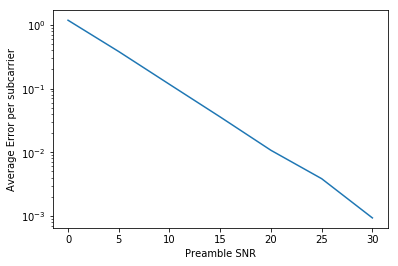

In [13]:
plt.semilogy(np.arange(0, N_SNR*5, 5), Err_DNN_normalized_hw)
plt.xlabel("Preamble SNR")
plt.ylabel("Average Error per subcarrier")
plt.show()

In [14]:
IP_output[0]

array([[-1.03812897, -0.89598602,  0.1085    , ...,  0.70032901,
         0.113018  , -0.30190101],
       [ 0.157701  ,  0.63607299,  1.21284997, ..., -0.91760498,
        -0.66222203,  0.200697  ],
       [ 0.74327499,  1.10473502, -0.63569999, ..., -0.98781198,
        -1.51866806, -1.83411503],
       ...,
       [ 0.82737899,  0.90943497, -1.100577  , ...,  0.51791501,
         0.415315  ,  0.116634  ],
       [-0.27631101, -0.171382  ,  0.34815499, ..., -1.04417801,
        -1.10378003, -0.83997703],
       [ 0.88639802,  0.54068798, -0.97302598, ...,  0.129384  ,
         0.25719199,  0.016987  ]])